<a href="https://colab.research.google.com/github/Anshul-hub69/task04/blob/main/Task04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
up = files.upload()          # pick your file in the dialog
fname = list(up.keys())[0]   # auto-grab the uploaded filename
fname

Saving synthetic_accident_data.csv to synthetic_accident_data (2).csv


'synthetic_accident_data (2).csv'

In [4]:
import pandas as pd

# Try common separators; fall back to comma
try:
    df = pd.read_csv(fname, sep=None, engine="python", encoding_errors="ignore")
except Exception:
    df = pd.read_csv(fname, encoding_errors="ignore")

print("Shape:", df.shape)
display(df.head())
df.info()


Shape: (5000, 10)


,accident_id,date,time,latitude,longitude,weather,road_condition,light_condition,severity,vehicles_involved
0,1,2023-01-01,02:48:00,28.589528,77.250164,Clear,Dry,Daylight,2,1
1,2,2023-01-01,18:03:00,28.659158,77.185783,Clear,Dry,Dark - Lit,3,3
2,3,2023-01-01,07:54:00,28.634148,77.188385,Rain,Dry,Dawn/Dusk,5,1
3,4,2023-01-01,05:28:00,28.716880,77.288057,Clear,Wet,Daylight,2,5
4,5,2023-01-01,01:01:00,28.649122,77.327109,Rain,Dry,Daylight,4,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accident_id        5000 non-null   int64  
 1   date               5000 non-null   object 
 2   time               5000 non-null   object 
 3   latitude           5000 non-null   float64
 4   longitude          5000 non-null   float64
 5   weather            5000 non-null   object 
 6   road_condition     5000 non-null   object 
 7   light_condition    5000 non-null   object 
 8   severity           5000 non-null   int64  
 9   vehicles_involved  5000 non-null   int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 390.8+ KB


In [5]:
df.columns = df.columns.str.strip().str.lower()
miss = df.isna().sum().sort_values(ascending=False)
miss.head(15)

,0
accident_id,0
date,0
time,0
latitude,0
longitude,0
weather,0
road_condition,0
light_condition,0
severity,0
vehicles_involved,0


In [6]:
# Helper to pick first column that exists
def pick(candidates):
    return next((c for c in candidates if c in df.columns), None)

col_date     = pick(['date','crash_date','accident_date','start_time','datetime'])
col_time     = pick(['time','crash_time','start_time'])
col_severity = pick(['accident_severity','severity','seriousness'])
col_weather  = pick(['weather_conditions','weather_condition','weather'])
col_road     = pick(['road_surface_conditions','road_conditions','road_condition','surface','surface_condition'])
col_light    = pick(['light_conditions','lighting','light_condition'])
col_lat      = pick(['latitude','lat'])
col_lon      = pick(['longitude','lon','lng'])

print({
    'date': col_date, 'time': col_time, 'severity': col_severity,
    'weather': col_weather, 'road': col_road, 'light': col_light,
    'lat': col_lat, 'lon': col_lon
})

{'date': 'date', 'time': 'time', 'severity': 'severity', 'weather': 'weather', 'road': 'road_condition', 'light': 'light_condition', 'lat': 'latitude', 'lon': 'longitude'}


In [7]:
import numpy as np

dt = None
if col_date and col_time and col_date != col_time:
    # Combine date + time columns
    dt = pd.to_datetime(df[col_date].astype(str) + " " + df[col_time].astype(str), errors='coerce')
elif col_date:
    dt = pd.to_datetime(df[col_date], errors='coerce')
elif col_time:
    dt = pd.to_datetime(df[col_time], errors='coerce')

if dt is not None:
    df['dt'] = dt
    df['year']  = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['day']   = df['dt'].dt.day
    df['hour']  = df['dt'].dt.hour
    df['dow']   = df['dt'].dt.dayofweek       # 0=Mon
    df['dow_name'] = df['dt'].dt.day_name()
else:
    print("⚠️ Could not parse a datetime column — time-based charts will be skipped.")


In [8]:
# Trim strings on key categoricals if they exist
for c in [col_weather, col_road, col_light]:
    if c:
        df[c] = df[c].astype(str).str.strip()

# If severity is categorical strings (e.g., 'Slight/Serious/Fatal'), keep as is.
# If numeric, ensure integer
if col_severity and pd.api.types.is_numeric_dtype(df[col_severity]):
    df[col_severity] = pd.to_numeric(df[col_severity], errors='coerce').astype('Int64')


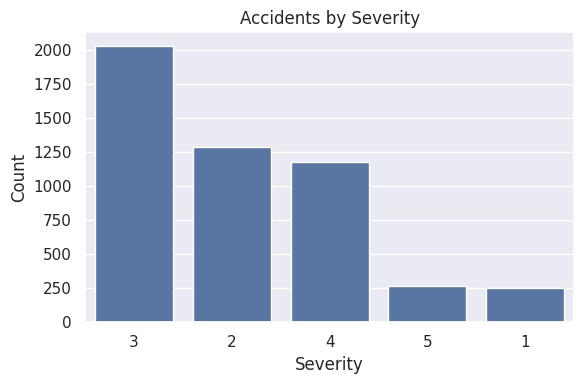

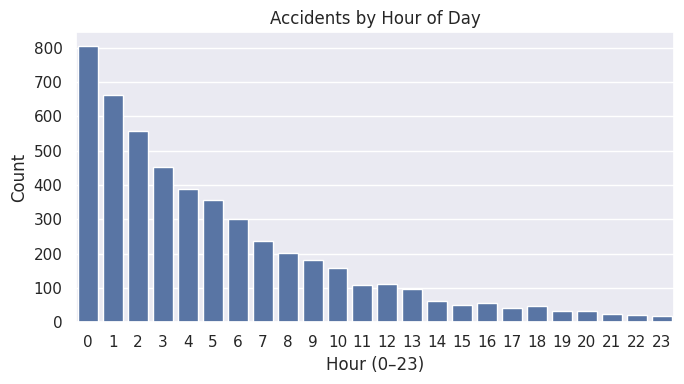

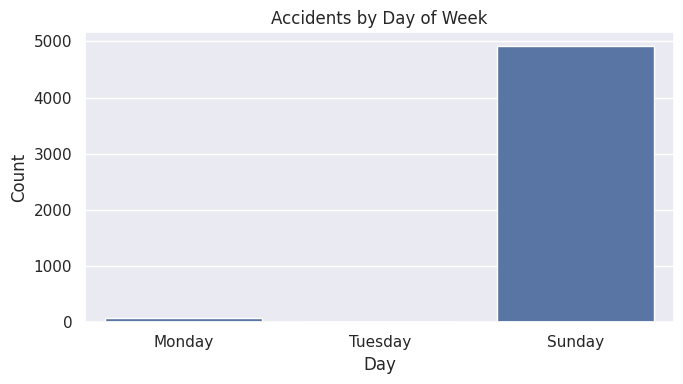

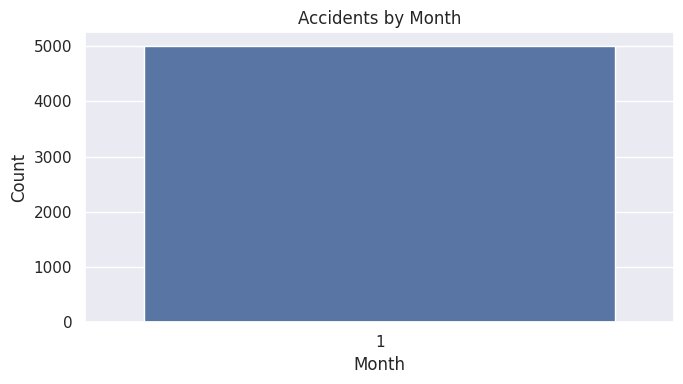

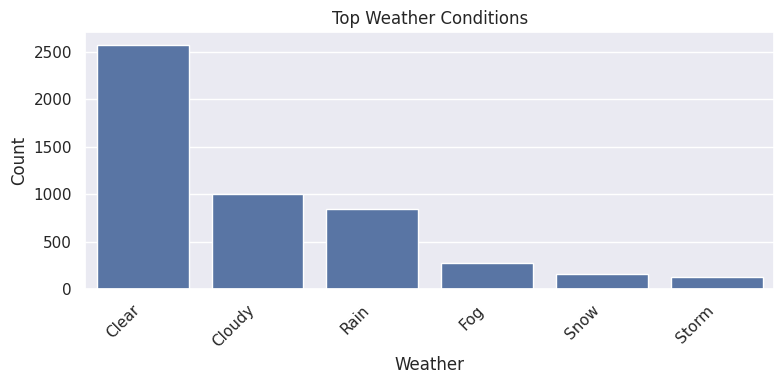

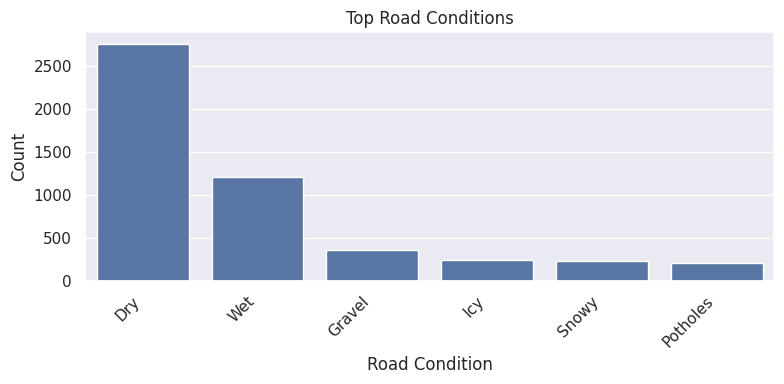

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# 7a) Severity distribution
if col_severity:
    plt.figure(figsize=(6,4))
    order = df[col_severity].value_counts().index
    sns.countplot(x=col_severity, data=df, order=order)
    plt.title("Accidents by Severity")
    plt.xlabel(col_severity.title())
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("01_severity.png", dpi=150)
    plt.show()

# 7b) Accidents by hour
if 'hour' in df.columns:
    plt.figure(figsize=(7,4))
    sns.countplot(x='hour', data=df, order=sorted(df['hour'].dropna().unique()))
    plt.title("Accidents by Hour of Day")
    plt.xlabel("Hour (0–23)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("02_by_hour.png", dpi=150)
    plt.show()

# 7c) Accidents by day of week
if 'dow_name' in df.columns:
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    avail = [d for d in order if d in df['dow_name'].unique()]
    plt.figure(figsize=(7,4))
    sns.countplot(x='dow_name', data=df, order=avail)
    plt.title("Accidents by Day of Week")
    plt.xlabel("Day")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("03_by_dow.png", dpi=150)
    plt.show()

# 7d) Accidents by month
if 'month' in df.columns:
    plt.figure(figsize=(7,4))
    sns.countplot(x='month', data=df, order=sorted(df['month'].dropna().unique()))
    plt.title("Accidents by Month")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("04_by_month.png", dpi=150)
    plt.show()

# 7e) Top weather conditions
if col_weather:
    plt.figure(figsize=(8,4))
    vc = df[col_weather].value_counts(dropna=False).head(10)
    sns.barplot(x=vc.index, y=vc.values)
    plt.title("Top Weather Conditions")
    plt.xlabel("Weather")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("05_weather.png", dpi=150)
    plt.show()

# 7f) Road surface/condition
if col_road:
    plt.figure(figsize=(8,4))
    vc = df[col_road].value_counts(dropna=False).head(10)
    sns.barplot(x=vc.index, y=vc.values)
    plt.title("Top Road Conditions")
    plt.xlabel("Road Condition")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("06_road.png", dpi=150)
    plt.show()


In [11]:
# Keep a light version for sharing (drop huge text cols if any)
light = df.copy()
for c in light.columns:
    if light[c].dtype == 'object' and light[c].str.len().mean() > 80:
        light = light.drop(columns=[c])
light.to_csv("accidents_clean_sample.csv", index=False)
"Saved: accidents_clean_sample.csv"


'Saved: accidents_clean_sample.csv'